In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load dataset
df = pd.read_csv('../data/PNQ_AQI.csv')

In [80]:
df = df.drop(columns=['SPM', 'CO2 µg/m3', 'Location'])

df.head()

,Date,SO2 µg/m3,Nox µg/m3,RSPM µg/m3,AQI
0,2009-01-01 00:00:00,15,53,179.0,153.0
1,2009-02-01 00:00:00,15,48,156.0,137.0
2,2009-03-01 00:00:00,13,51,164.0,143.0
3,2009-04-01 00:00:00,8,37,135.0,123.0
4,2009-07-01 00:00:00,13,36,140.0,127.0


In [83]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(by='Date')
df.replace(['BDL - NA', 'NA', 'NaN', '--'], np.nan, inplace=True)


cols = ['SO2 µg/m3','Nox µg/m3','RSPM µg/m3','AQI']

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Get Mean AQI for each date
df = df.groupby('Date')[cols].mean().reset_index()
print(df.head())
df.info()


        Date  SO2 µg/m3  Nox µg/m3  RSPM µg/m3    AQI
0 2009-01-01       17.0       56.5       170.0  147.0
1 2009-01-04       23.0       24.0       126.0  117.0
2 2009-01-05       20.5       29.5        89.5   88.5
3 2009-01-06       18.0       28.0        33.0   35.0
4 2009-01-07       19.0       24.0        20.0   30.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1010 non-null   datetime64[ns]
 1   SO2 µg/m3   1010 non-null   float64       
 2   Nox µg/m3   1010 non-null   float64       
 3   RSPM µg/m3  1010 non-null   float64       
 4   AQI         1010 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.6 KB


In [91]:
# Creating Features

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.weekday

df['AQI_N'] = df['AQI'].shift(-1)
df.dropna(inplace=True)
print(df.head())

print(df.isnull().sum())

        Date  SO2 µg/m3  Nox µg/m3  RSPM µg/m3    AQI  AQI_N  Month  Year  \
0 2009-01-01       17.0       56.5       170.0  147.0  117.0      1  2009   
1 2009-01-04       23.0       24.0       126.0  117.0   88.5      1  2009   
2 2009-01-05       20.5       29.5        89.5   88.5   35.0      1  2009   
3 2009-01-06       18.0       28.0        33.0   35.0   30.0      1  2009   
4 2009-01-07       19.0       24.0        20.0   30.0   45.0      1  2009   

   Weekday  
0        3  
1        6  
2        0  
3        1  
4        2  
Date          0
SO2 µg/m3     0
Nox µg/m3     0
RSPM µg/m3    0
AQI           0
AQI_N         0
Month         0
Year          0
Weekday       0
dtype: int64


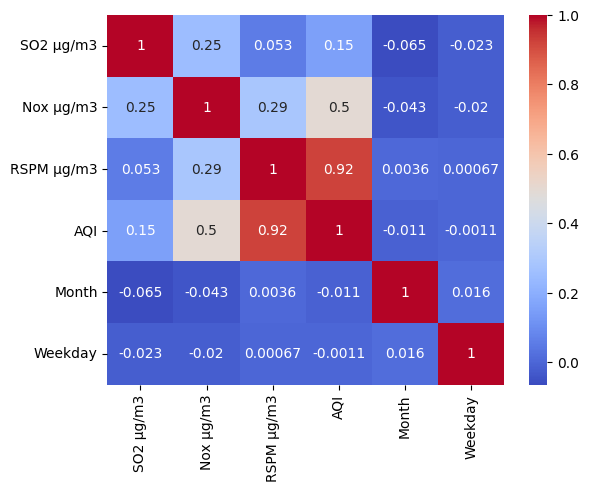

In [97]:
corrs_cols = ['SO2 µg/m3','Nox µg/m3','RSPM µg/m3','AQI','Month','Weekday']

sns.heatmap(df[corrs_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [112]:
from sklearn.model_selection import train_test_split
 

X = df[['SO2 µg/m3','Nox µg/m3','RSPM µg/m3','Month','Weekday']]
y = df['AQI_N']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)   

In [118]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=5, random_state=42, max_features='sqrt', min_samples_leaf=4, n_estimators=100, min_samples_split=2)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


MAE: 23.87746613518736
MSE: 892.2499938791027
R2: 0.3702619533625344


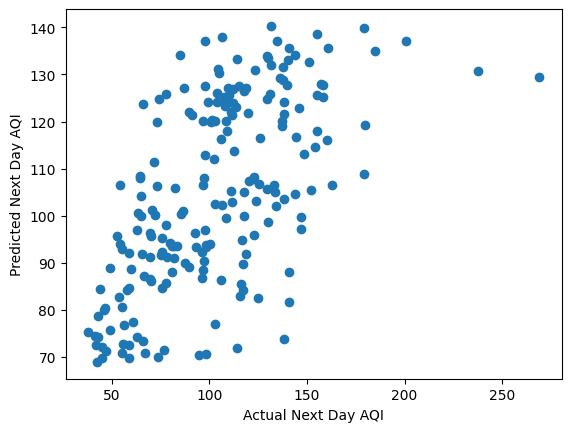

In [119]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Next Day AQI")
plt.ylabel("Predicted Next Day AQI")
plt.show()


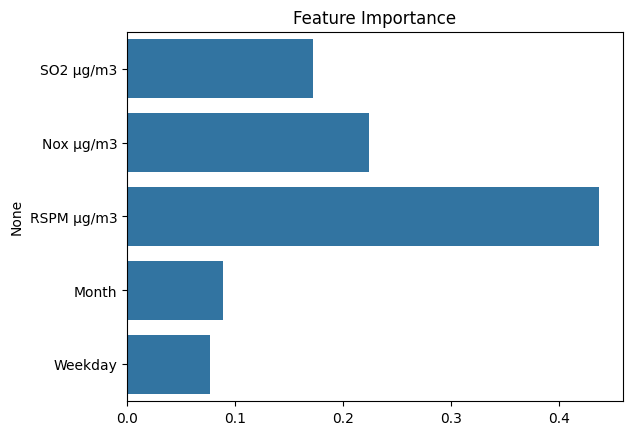

In [115]:
import seaborn as sns

importance = model.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.title("Feature Importance")
plt.show()
